In [2]:
#Importamos algunas librerias de utilidad
import numpy as np
from enum import Enum
import random
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import clear_output
from random import randrange

<h3>Descripción de la implementación</h3>

<p>El programa que se implementó consta de las siguientes clases: </p>

<ol>
    <p><li><b>Point: </b>Esta clase engloba todas las propiedades que pueden tener los puntos del triángulo de Sierpinski dentro del problema que buscamos resolver. Estas serían sus coordenadas "x" y "y", el color del punto y la generación o iteración en la cual fue creado.</li></p>
    <p><li><b>Triangle:</b> Esta clase se utiliza para describir a los triángulos que conforman al fractal de Sierpinski. Cada uno de ellos consta de 3 puntos distintos, y se debe especificar si se trata de uno de los triángulos que se han removido (no válidos) o si es uno de los que se dividirá en la generación siguiente. Los triangulos se pintan de colores distintos dependiendo de sin válidos o no, así que dentro de la clase se ha especificado en formato hexadecimal el color a asignar para estas dos variantes.</li></p>

<p><li><b>DistanceType: </b>Esta es una clase de tipo Enum, que utilizamos para categorizar los tipos de distancia que podemos tener, los valores posibles en este caso son <code>EUCLIDEAN</code>, <code>MANHATTAN</code>, <code>MINKOWSKI</code>, <code>GENERATION</code> e <code>INVENTED_PARABOLIC</code>.</li></p>
    
<p><li><b>DistanceCalculator: </b> Contiene métodos para calcular diferentes distancias entre objetos de tipo <code>Point</code>. En el caso de las distancias Euclidiana y Manhattan lo que se hace es mandar a llamar a la función de distancia de Minkowski con ordenes p = 2 y p = 1 respectivamente, ya que son casos particulares de esta. La clase contiene un método general llamado calculateDistance, el cual además de dos puntos recibe como argumento un objeto de tipo <code>DistanceType</code>, con el cual se especifica el tipo de distancia a calcular. En el caso de la distancia Minkowski este método utiliza por defecto un valor de orden igual a 5.</li></p>
    
<p><li><b>ColorGenerator: </b> es la clase utilizada para obtener los colores que se asignan a los puntos del triángulo de Sierpinski. Uno de los métodos, llamado <code>getRandomColor</code> regresa una cadena con el código hexadecimal de un color seleccionado en forma aleatoria; mientras que otro denominado <code>getGradientColor</code> asigna al valor que se proporcione, un color en una escala que va desde azul (valor 0) a amarillo (valor máximo que se debe dar como argumento a la función).</li></p>
 
<p><li><b>SierpinskiGasket: </b> Esta constituye la clase principal del programa, y se auxilia de las clases que se han descrito ya en los puntos anteriores. El método principal se nombró <code>evolve</code>. Esta función recursiva genera los tríangulos y puntos que conforman al tríangulo de Sierpinski hasta la generación que se le indique. La clase cuenta también con métodos que permiten colorear los puntos acorde a su distancia promedio, aquí fueron dos tipos de coloración las que se decidió examinar: por gradiente (lo cual resulta en cambio de color mas continuo) y aleatorio (útil para observar que patrón presentan los puntos con una misma distancia promedio).</li> </p></ol>

In [3]:
#Vamos a comenzar programando algunas clases que nso harán la vida mas fácil
class Point:
    def __init__(self, x, y):
        #Cada punto va a tener una posición
        self.x = x
        self.y = y
        
        self.color = "#03c6fc"
        #Otro parámetro importante es la generacióno donde aparece el punto
        self.generation = 0
        
    def getPosition(self):
        return [x,y]

class Triangle:
    
    def __init__(self, point1, point2, point3):
        #Checamos que formen un ciclo los 3 lados
        self.point1 = point1
        self.point2 = point2
        self.point3 = point3
        self.valid = True
        self.validTriangleColor = "#34b1eb"
        self.nonValidTriangleColor = "#ffd438"

    def getColor(self):
        if(self.valid):
            return self.validTriangleColor
        else:
            return self.nonValidTriangleColor
    
    def getVertices(self):
        return [self.point1, self.point2, self.point3]
    
    def getClosedVertices(self):
        return [self.point1, self.point2, self.point3, self.point1]
    
    def isValid(self):
        return self.valid

    
class DistanceType(Enum):
    EUCLIDEAN = 0
    MANHATTAN = 1
    MINKOWSKI = 2
    GENERATION = 3
    INVENTED_HYPERBOLIC = 4
    
    
#También construiremos una clase para calcular las distancias entre puntos
class DistanceCalculator:
    
    def calculateDistance(self, point1, point2, distType):
        if(distType == DistanceType.EUCLIDEAN):
            return self.euclideanDistance(point1, point2)
        elif(distType == DistanceType.MANHATTAN):
            return self.manhattanDistance(point1, point2)
        elif(distType == DistanceType.MINKOWSKI):
            return self.minkowskiDistance(point1, point2, 5)
        elif(distType == DistanceType.GENERATION):
            return self.timeLineDistance(point1, point2)
        elif(distType == DistanceType.INVENTED_HYPERBOLIC):
            return np.sinh(point1.x**2) + np.sinh(point2.x**2) + np.sinh(point1.y**2) + np.sinh(point2.y**2)
        else:
            return None
    
    def minkowskiDistance(self, point1, point2, p):
        return (np.abs(point1.x - point2.x)**(p) + np.abs(point1.y - point2.y)**(p))**(1/p)
    
    #Las distancias euclideana y manhattan son la distancia minkowski de orden 2 y 1 respectivamente
    def euclideanDistance(self, point1, point2):
        return self.minkowskiDistance(point1, point2, 2)
    
    def manhattanDistance(self, point1, point2):
        return self.minkowskiDistance(point1, point2, 1)
    
    def timeLineDistance(self, point1, point2):
        return np.abs(point1.generation - point2.generation)
    
    
    
class ColorGenerator:
    
    def __init__(self):
        self.startColor = np.array([0.137, 0, 0.960])
        self.endColor = np.array([0.984, 0.792, 0.094])
        self.grad = self.endColor - self.startColor
        
    
    #Regresa un esquema de colores aleatorio
    def buildRandomScheme(self, numberOfColors):
        colorStrings = []
        for i in range(0,numberOfColors):
            s = "#"
            r = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
            g = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
            b = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
            s = s+r+g+b
            colorStrings.append(s)
        
        return colorStrings
        
    def getRandomColor(self):
        s = "#"
        r = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        g = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        b = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        s = s+r+g+b
        
        return s
    
    def getGradientColor(self, maxValue, value):
        color = self.startColor + (value/maxValue)*self.grad
        color = color*255
        s = '#%02x%02x%02x' % (int(color[0]), int(color[1]), int(color[2]))
        return s
    
    
#Finalmente construimos la clase con la cual obtendremos el trianguylo de sierpinski
class SierpinskiGasket:
    
    def __init__(self,l, generations):
        self.l = l
        #Construimos el triangulo inicial
        point1 = Point(-l/2,0)
        point2 = Point(l/2,0)
        point3 = Point(0, (np.sqrt(3)/2)*l)
        
        self.points = [point1, point2, point3]
        
        initialTriangle = Triangle(point1,point2,point3)
        self.initialTriangle = initialTriangle
        self.triangles = [initialTriangle]
        self.generations = generations
        
    def resetGasket(self):
        self.triangles = [self.initialTriangle]
    
    
    def evolve(self, triangles, generations):
        if(generations == 0):
            self.triangles = triangles
            return
        newTriangles = []
        generationColor = ColorGenerator().getRandomColor()
        generationTag = self.generations - generations +1
        for i in range(0,len(triangles)):
            triangle = triangles[i]
            if(triangle.isValid()):
                vertices = triangle.getVertices()
                #Obtenemos los 3 puntos medios
                p1 = vertices[0]
                p2 = vertices[1]
                p3 = vertices[2]
                middleX1 = (p1.x + p2.x)/2
                middleY1 = (p1.y + p2.y)/2
                middleX2 = (p2.x + p3.x)/2
                middleY2 = (p2.y + p3.y)/2
                middleX3 = (p3.x + p1.x)/2
                middleY3 = (p3.y + p1.y)/2
            
                middle1 = Point(middleX1, middleY1)
                middle1.color = generationColor
                middle1.generation = generationTag
                middle2 = Point(middleX2, middleY2)
                middle2.color = generationColor
                middle2.generation = generationTag
                middle3 = Point(middleX3, middleY3)
                middle3.color = generationColor
                middle3.generation = generationTag
                self.points.append(middle1)
                self.points.append(middle2)
                self.points.append(middle3)
            
                #Creamos un triangulo (no valido con los puntos del medio)
                #Este es el triangulo central que estamos retirando
                invalidTriangle = Triangle(middle1, middle2, middle3)
                invalidTriangle.valid = False
                newTriangles.append(invalidTriangle)
                #Ahora creamos los 3 triangulos validos nuevos y los agregamos
            
                newTriangles.append(Triangle(middle3, middle2, p3))
                newTriangles.append(Triangle(p1, middle1, middle3))
                newTriangles.append(Triangle(middle1, p2, middle2))
            else:
                newTriangles.append(triangle)
        self.evolve(newTriangles,generations-1)
        
    
    def drawGasket(self):
        n = len(self.triangles)
        for i in range(0,n):
            triangle = self.triangles[i]
            xy = np.zeros((4,2))
            verts = triangle.getClosedVertices()
            points = triangle.getVertices()
            for j in range(0,len(verts)):
                vert = verts[j]
                xy[j,:] = np.array([vert.x, vert.y])
            
            for j in range(0,len(points)):
                vert = verts[j]
                plt.plot([vert.x],[vert.y],color = vert.color, marker = 'o', markersize = 4)
                
            tr = plt.Polygon(xy, edgecolor = None, facecolor = triangle.getColor())
            plt.gca().add_patch(tr)
        
        plt.show()
    
    def drawPointGasket(self):
        plt.figure(figsize = (10,10))
        n = len(self.points)
        legends = []
        hand = []
        for i in range(0,n):
            point = self.points[i]
            if(point.generation not in legends):
                rep = plt.plot([point.x],[point.y],color = point.color, marker = 'o', markersize = 4, label = " generación "+str(point.generation))
                legends.append(point.generation)
                hand.append(rep)
            else:
                plt.plot([point.x],[point.y],color = point.color, marker = 'o', markersize = 4)
                
            #tr = plt.Polygon(xy, edgecolor = None, facecolor = triangle.getColor())
            #plt.gca().add_patch(tr)
        plt.legend()
        plt.show()
    
    def drawDistanceGasket(self):
        plt.figure(figsize = (10,10))
        n = len(self.points)
        legends = [str(self.minDistance), str(self.maxDistance)]
        minDistanceLabeled = False
        maxDistanceLabeled = False
        for i in range(0,n):
            point = self.points[i]
            if(not minDistanceLabeled and point.color == self.minColor):
                plt.plot([point.x],[point.y],color = point.color, marker = 'o', markersize = 4, label = "Distancia mínima "  +str(self.minDistance))
                minDistanceLabeled = True
                
            elif(not maxDistanceLabeled and point.color == self.maxColor):
                plt.plot([point.x],[point.y],color = point.color, marker = 'o', markersize = 4, label = "Distancia máxima " +str(self.maxDistance))
                maxDistanceLabeled = True
            else:
                plt.plot([point.x],[point.y],color = point.color, marker = 'o', markersize = 4)
                
            #tr = plt.Polygon(xy, edgecolor = None, facecolor = triangle.getColor())
            #plt.gca().add_patch(tr)
        plt.legend()
        plt.show()
        
    
    def colorByGradientDistance(self, normType, maxVal):
        calculator = DistanceCalculator()
        artist = ColorGenerator()
        #Número de triangulos
        n = len(self.points)
        colorDictionary = {}
        minDistance = float('inf')
        maxDistance = float('-inf')
        minColor = None
        maxColor = None
        for i in range(0,n):
            point = self.points[i]
            d = 0
            for j in range(0,n):
                d += (1/n)*calculator.calculateDistance(point, self.points[j], normType)
        
            d = str(round(d,2))
            if(not d in colorDictionary.keys()):
                color = artist.getGradientColor(maxVal,float(d))
                colorDictionary[d] = color
                point.color = color
                
                if(float(d) < minDistance):
                    minDistance = float(d)
                    minColor = color
                
                if(float(d) > maxDistance):
                    maxDistance = float(d)
                    maxColor = color
                
            else:
                point.color = colorDictionary[d]
        
        self.maxColor = maxColor
        self.minColor = minColor
        self.maxDistance = maxDistance
        self.minDistance = minDistance
        
    def colorRandomDistance(self, normType):
        calculator = DistanceCalculator()
        artist = ColorGenerator()
        #Número de triangulos
        n = len(self.points)
        colorDictionary = {}
        minDistance = float('inf')
        maxDistance = float('-inf')
        minColor = None
        maxColor = None
        for i in range(0,n):
            point = self.points[i]
            d = 0
            for j in range(0,n):
                d += (1/n)*calculator.calculateDistance(point, self.points[j], normType)
        
            d = str(round(d,2))
            if(not d in colorDictionary.keys()):
                color = artist.getRandomColor()
                colorDictionary[d] = color
                point.color = color
                
                if(float(d) < minDistance):
                    minDistance = float(d)
                    minColor = color
                
                if(float(d) > maxDistance):
                    maxDistance = float(d)
                    maxColor = color
                
            else:
                point.color = colorDictionary[d]
        
        self.maxColor = maxColor
        self.minColor = minColor
        self.maxDistance = maxDistance
        self.minDistance = minDistance
        
        

<h3>Prueba de funcionamiento</h3>

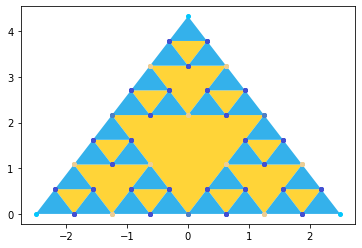

In [6]:
#Prueba para ver que se este dibujando correctamente el triangulo
l = 5
generations = 3

gasket = SierpinskiGasket(l,generations)
gasket.evolve(gasket.triangles,generations)
gasket.drawGasket()

<h3>0.- Coloración de los puntos del triangulo por la generación en que aparecieron</h3>

Se presenta ahora el triangulo de Sierpinski con sus puntos coloreados acorde a la generación en que aparecieron. Algo que es pertinente mencionar es que el conteo de las generaciones dentro del programa empieza desde 0, por lo cual aunque el argumento indique que son 6 generaciones realmente dentro del dibujo son 7 recursiones las que se están dibujando.  

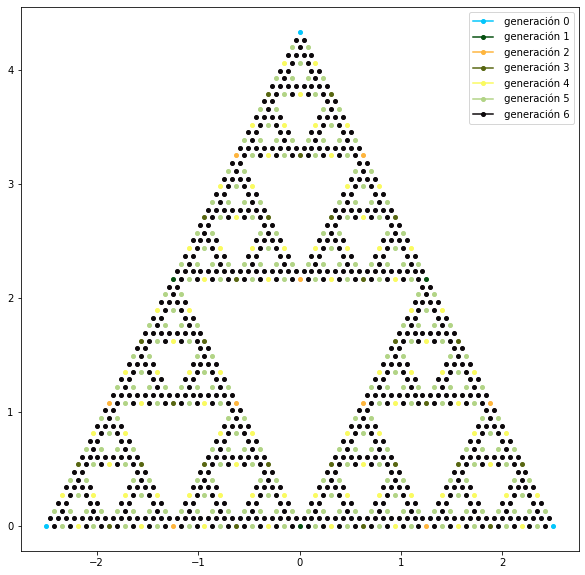

In [9]:
l = 5
generations = 6

gasket = SierpinskiGasket(l,generations)
gasket.evolve(gasket.triangles,generations)
gasket.drawPointGasket()

<h3>1.- Distancia Euclidiana</h3>

<h4>1.1.- Coloración por gradiente</h4>

In [10]:
maxVal = 3.09
minVal = 1.68
distType = DistanceType.EUCLIDEAN
gasket.colorByGradientDistance(distType,maxVal)

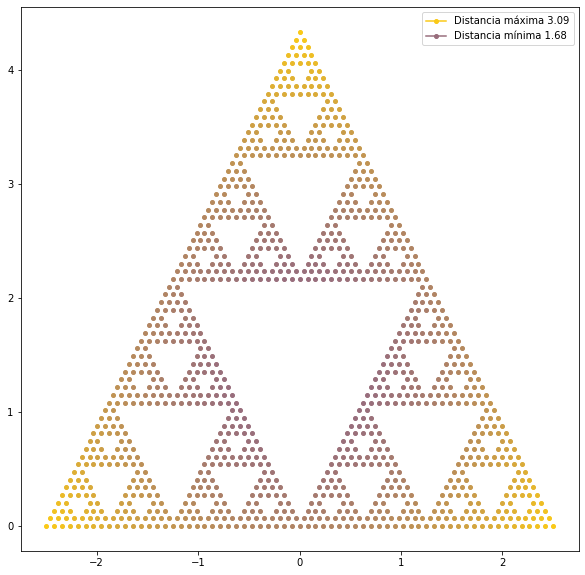

In [11]:
gasket.drawDistanceGasket()

<h4>1.2. Asignación aleatoria de color a los puntos que presentan la misma distancia promedio</h4>

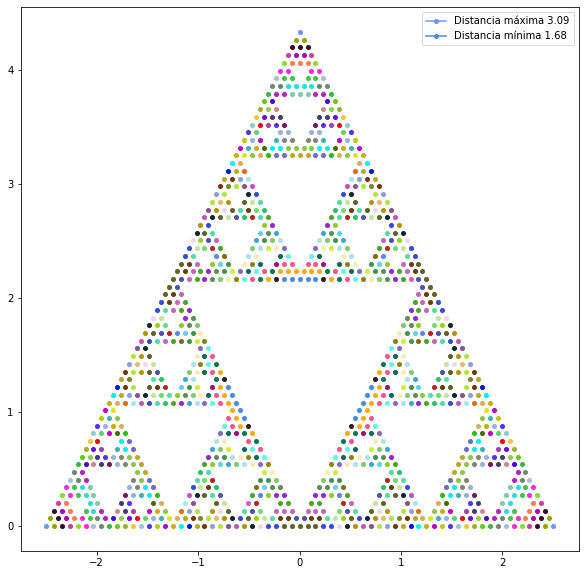

In [13]:
gasket.colorRandomDistance(distType)
gasket.drawDistanceGasket()

<h4>1.3. Patrón observado</h4>

El patrón que se observa en la coloración por gradiente es uno donde el valor de la distancia promedio va creciendo desde el centro del triangulo hasta llegar a su valor máximo en los vertices del mismo. Este comportamiento hace sentido, ya que es cerca del centro donde se acumulan mas puntos del triangulo; como para estos la mayoría de los puntos están cerca esperariamos que se tenga una menor distancia promedio. 


La coloración aleatoria exhibe varias cosas interesantes, una de ellas es que hay una simetría entre los colores en las mitades derecha e izquierda del triangulo. Si lo pensamos esta simetría es consecuencia de dos cosas:

<ol>
    <li>Que la distancia cumple la propiedad de simetría</li>
   <li>Que la figura es simétrica en el sentido de que hay el mismo número de puntos en la mitad derecha y la mitad izquierda</li>
</ol>

La observación quizás no sea la más informativa pero se me hizo interesante que la propiedad de simetría de la distancia se relacione con la simetría de las figuras. 

Otra  de las cosas que se observa es que la distancia promedio mínima se encuentra en los puntos ubicados a la mitad de los lados del triángulo central, esto es interesante porque teoricamente el punto con distancia promedio menor en un triangulo es el centroide del mismo, y dicho centroide se encuentra en la intersección de 3 lineas llamadas medianas que pasan por los puntos medios de los lados del triangulo. De este modo, el resultado concuerda con lo que esperariamos si usaramos geometría plana para analizar nuestro problema. 

Lo que quería ejemplificar con mi observación anterior es que usar la norma euclidiana resulta en patrones que cumplen leyes y propiedades geométricas de la geometría plana a la que estamos acostumbrados. Por tanto en cierto sentido abrir la posibilidad de usar otro tipo de métrica implicitamente permite examinar los datos bajo otro tipo de geometrías, las cuales pueden exhibir otro tipo de leyes y relaciones mas allá de lo que nos es familiar. 



<h3>2.-Distancia Manhattan</h3>

<h4>2.1.- Coloración por gradiente</h4>

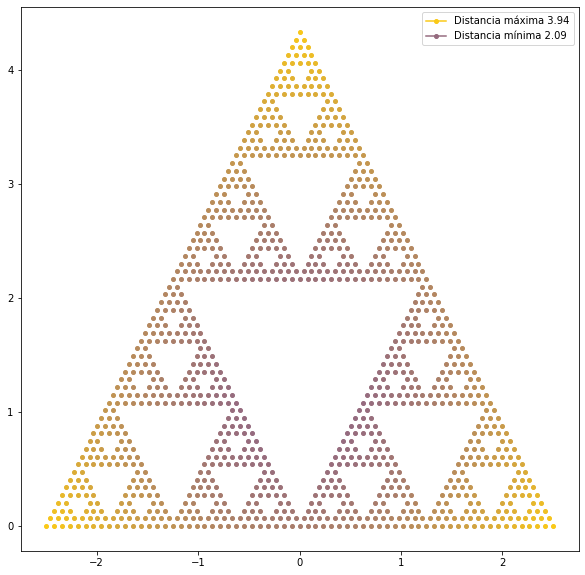

In [14]:
maxVal = 3.94
minVal = 1.68
distType = DistanceType.MANHATTAN
gasket.colorByGradientDistance(distType,maxVal)
gasket.drawDistanceGasket()

<h4>2.2. Asignación aleatoria de color a los puntos que presentan la misma distancia promedio</h4>

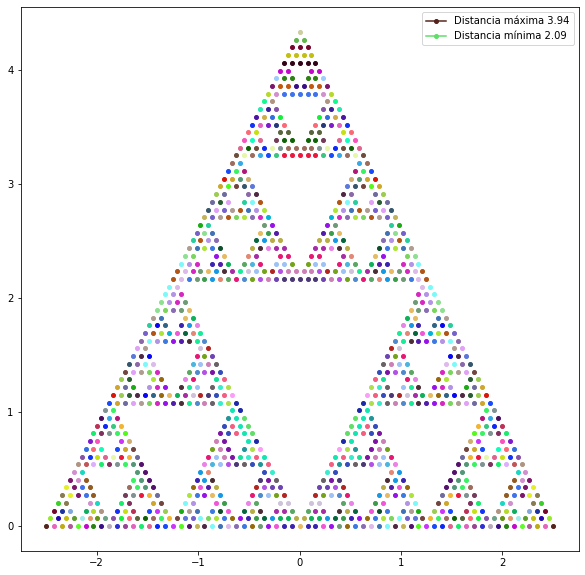

In [15]:
gasket.colorRandomDistance(distType)
gasket.drawDistanceGasket()

<h4>2.3.- Patrón observado</h4>

Uno de los cambios importantes que se observan respecto a la distancia Euclidiana es que los valores mínimos ya no se encuentran a la mitad de los 3 lados del triángulo interno. En este caso se ubican unicamente en los dos lados con ángulo distinto de cero respecto a la base del triángulo. Este es el primer indicio claro de que estamos tratando con una geometría fundamentalmente distinta. 

En la siguiente figura he tratado de ejemplificar a lo que me refiero:

<img src = "manhattan.png" width = "200" height = "200"/>

Notese que cuando evaluamos la distancia desde algún punto ubicado en una linea a 0° a alguno perteneciente a otra recta con cierto ángulo, digamos 30°, la distancia en el eje "y" que se debe recorrer es siempre la misma, independientemente del punto desde el cual partamos.  Sin embargo cuando partimos de puntos en una recta con el mismo ángulo la distancia en "y" puede ir disminuyendo conforme nos acercamos a la altura del punto, así también lo hace la componente "x".

Como hipótesis podríamos plantear entonces que la distancia manhattan promedio debería encontrarse necesariamente en rectas paralelas a los lados del triangulo, ya sea a 30° o a -30°. 


<h3>3.-Distancia Minkowski</h3>

<h4>3.1.- Coloración por gradiente</h4>

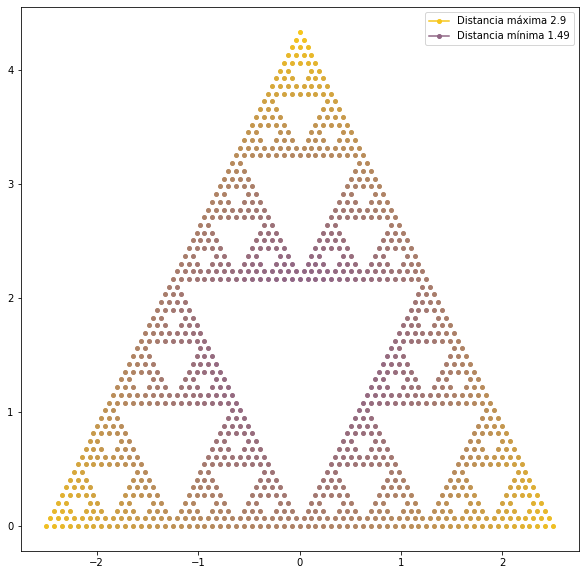

In [16]:
maxVal = 2.95
minVal = 1.68
distType = DistanceType.MINKOWSKI
gasket.colorByGradientDistance(distType,maxVal)
gasket.drawDistanceGasket()

<h4>3.2.-Coloración de puntos con distancias iguales asignada aleatoriamente</h4>

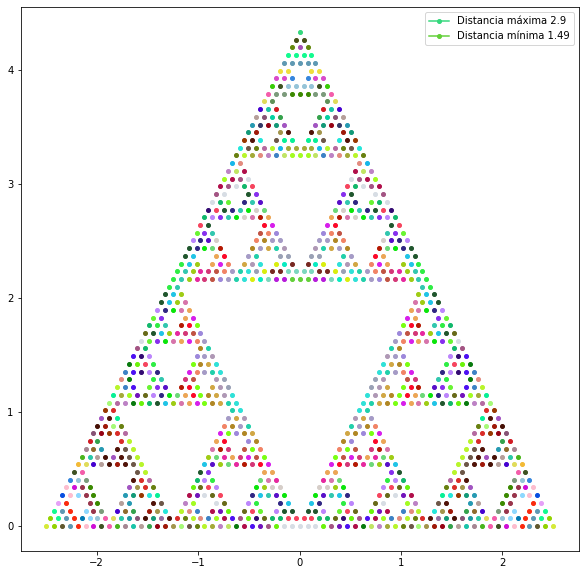

In [17]:
gasket.colorRandomDistance(distType)
gasket.drawDistanceGasket()

<h4>3.3.- Patrón observado</h4>

La distancía minkowski presenta un patrón un tanto mas similar al de la distancia manhattan, en el sentido de que los mínimos se hallan unicamente en dos de los lados del tríangulo interno. Una de las hipótesis que tengo es que para ordenes impares (en este caso se uso p=5), dichos mínimos se encontraran en dos lados solamente, mientras que para ordenes pares se encontrarán en los tres lados. 

<h3>4.- Distancia de generación</h3>

Una cuestión que quedó por resolverse en clase respecto a este caso es la demostración de que en efecto la distancia propuesta cumple las propiedades de una norma. 

Como recordatorio, estas eran:
<ol>
    <li>$D(x,y) \geq 0$</li>
    <li>$D(x,y) = D(y,x)$</li>
    <li>$D(x,y) \leq D(x,y) + D(y,z)$</li>
</ol>

Ahora, si abstraemos un poco la definición de la norma propuesta podernos darnos cuenta de que realmente esta es simplemente un valor absoluto. Es decir supongamos que la generación en la cual aparece un punto $P_{1}$ es $n_{1}$ y que la generación en la cual aparece un punto $P_{2}$ es $n_{2}$, la norma vendría dada por:

\begin{equation}
d(P_{1},P_{2}) = |n_{1} - n_{2}|
\end{equation}

La distancia propuesta hereda todas las propiedades del valor absoluto, en particular se cumplen las 3 propiedades que ya se han enunciado. 

<h4>4.1.- Coloración por gradiente</h4>

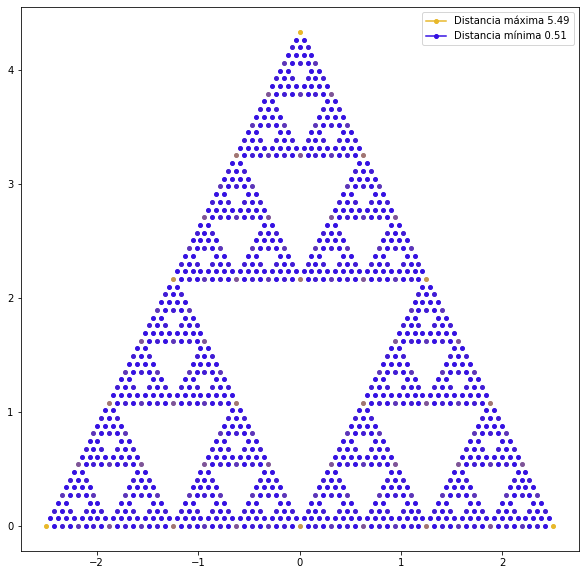

In [23]:
maxVal = 6
minVal = 1.68
distType = DistanceType.GENERATION
gasket.colorByGradientDistance(distType,maxVal)
gasket.drawDistanceGasket()

<h4>4.2.-Coloración de puntos con distancias iguales asignada aleatoriamente</h4>

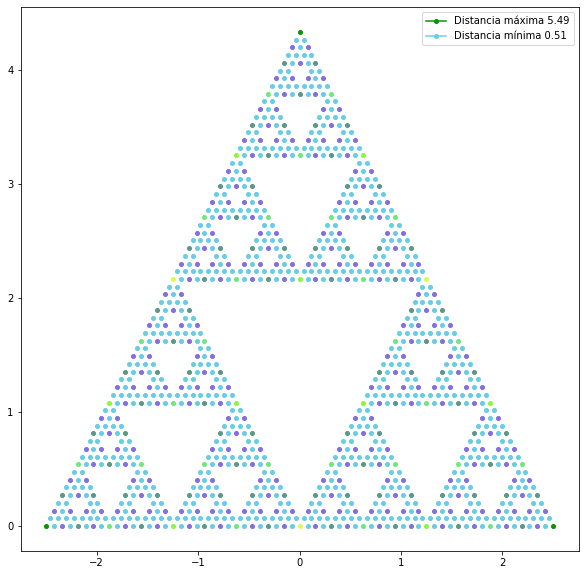

In [24]:
gasket.colorRandomDistance(distType)
gasket.drawDistanceGasket()

<h4>4.3.- Patrón observado</h4>

En este caso el patrón que surge es basicamente el mismo que al colorear por la generación en la cual aparecen los puntos. 

<h3>5.- Proponer otra distancia</h3>

Solo como intuición pareciera ser que los candidatos a ser norma serían las funciones crecientes y positivas tales que f(0) = 0, como ocurre con el valor absoluto y la raiz cuadrada.  

Uno de estos es el seno hiperbólico, cuya gráfica mostrare a continuación:


Text(0.5, 1.0, 'Seno hiperbólico')

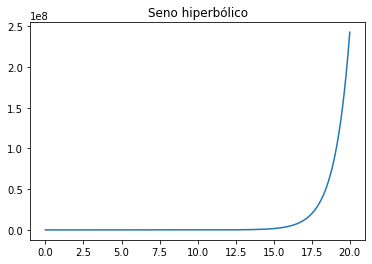

In [20]:
x = np.linspace(0,20, 1000)
y = np.sinh(x)
plt.plot(x,y)
plt.title("Seno hiperbólico")

Así que podriamos proponer alguna distancia con esta función, como la siguiente:

\begin{equation}
d(P_{1},P_{2}) = \sinh{(x_{1}^2)} + \sinh{(x_{2})^2} + \sinh{(y_{1}^2)} + \sinh{(y_{2}^2)}
\end{equation}

Probemos en primer lugar que en efecto se cumplen las tres propiedades de una norma:

<ol>
    <li>$d(P_{1},P_{2})\geq 0$: Dado que la función seno hiperbólico es positiva, todos los términos que constituyen la suma en la función de distancia son positivos, se sigue en consecuencia que:
        $$d(P_{1},P_{2})\geq 0$$</li>
    <li>$d(P_{1},P_{2}) = d(P_{2},P_{2})$: Esta propiedad es consecuencia de la conmutatividad de los números reales bajo la operación suma:
    $$d(P_{1},P_{2}) = \sinh{(x_{1}^2)} + \sinh{(x_{2})^2} + \sinh{(y_{1}^2)} + \sinh{(y_{2}^2)} = \sinh{(x_{2}^2)} + \sinh{(x_{1})^2} + \sinh{(y_{2}^2)} + \sinh{(y_{1}^2)} = d(P_{2},P_{1})$$
    </li>
    <li>$d(P_{1},P_{2}) \leq d(P_{1},P_{3}) + d(P_{3},P_{2})$
    Hagamos la cuenta:
    \begin{align}
        d(P_{1},P_{3}) + d(P_{3},P_{2}) &= \sinh{(x_{1}^2)} + \sinh{(x_{3})^2} + \sinh{(y_{1}^2)} + \sinh{(y_{3}^2)} +\sinh{(x_{3}^2)} + \sinh{(x_{2})^2} + \sinh{(y_{3}^2)} + \sinh{(y_{2}^2)}\\
        &= 2\sinh{(x_{3}^2)} + 2\sinh{(y_{3}^2)} +\sinh{(x_{1}^2)} + \sinh{(x_{2})^2} + \sinh{(y_{1}^2)} + \sinh{(y_{2}^2)}\\
        &=2\sinh{(x_{3}^2)} + 2\sinh{(y_{3}^2)} + d(P_{1},P_{2}) \geq d(P_{1},P_{2})
     \end{align}
    </li>
</ol>

Ya que hemos probado que nuestra norma es válida veamos como queda la clasificación por distancia promedio en el triangulo de sierpinski

<h4>5.1.- Coloración por gradiente</h4>

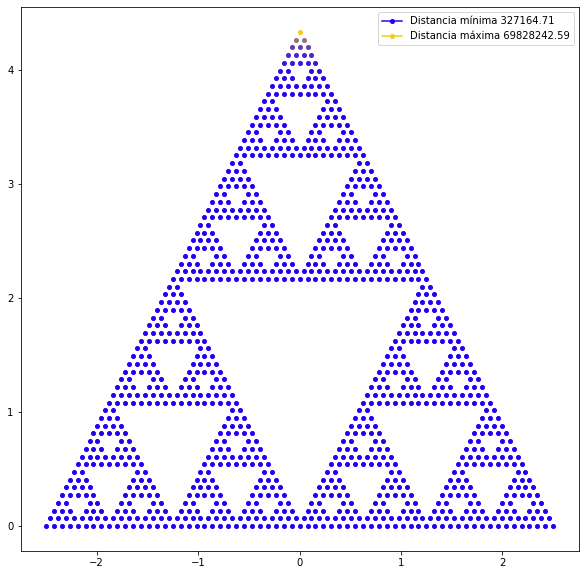

In [25]:
maxVal = 69828242.59
minVal = 1.68
distType = DistanceType.INVENTED_HYPERBOLIC
gasket.colorByGradientDistance(distType,maxVal)
gasket.drawDistanceGasket()

<h4>5.2.-Coloración de puntos con distancias iguales asignada aleatoriamente</h4>

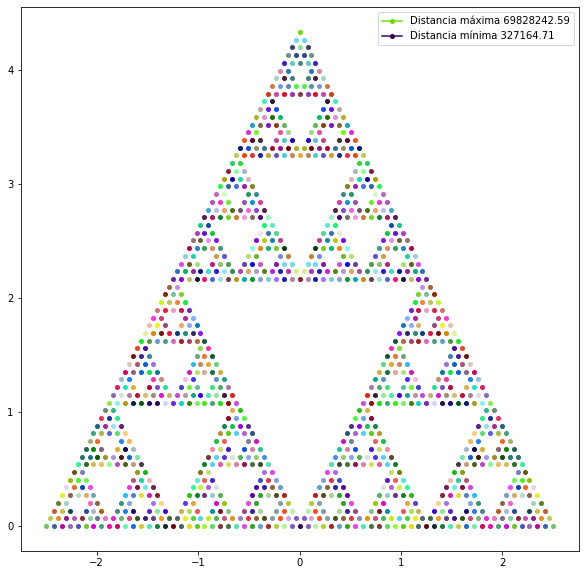

In [26]:
gasket.colorRandomDistance(distType)
gasket.drawDistanceGasket()


<h4>5.2.-Patrón observado</h4>

Respecto a la coloración por gradiente se observa una coloración no lineal donde casi todos los puntos presentan coloraciones similares excepto en la punta, en la cual se da un crecimiento súbito. Un comportamiento así es esperado para la norma propuesta porque el seno hiperbólico viene definida a partir de exponenciales:

\begin{equation}
\sinh{(x)} = \frac{e^{x} - e^{-x}}{2}
\end{equation}

Una cosa que no pude dejar de observar a partir del patrón aleatorio de coloración es que en esta caso también los mínimos solo suceden en dos lados!, pienso que esto puede estar relacionado con la naturaleza impar (f(x) = -f(-x)) del seno hiperbólico pero no estoy completamente seguro. 

Algo que me doy cuenta ahora que leo mis observaciones es que tiendo a querer extrapolar cosas teóricas generales a partir de los patrones, creo que pienso demasiado como físico, espero no me afecte demasiado en el análisis de datos complejos en un futuro. 